In [ ]:
!pip install statsmodels
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.5/280.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display  # (added so display(...) works in notebook)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from tensorflow import keras


In [ ]:
# Step 1: Load and explore the dataset
# You used two variants in your code. We'll try the local first, then root.
try:
    file_path = 'mpi_roof.csv'
    data = pd.read_csv(file_path, encoding='ISO-8859-1')
except FileNotFoundError:
    file_path = '/mpi_roof.csv'
    data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display summary statistics to understand the data distribution
summary_stats = data.describe()
print(summary_stats)


           p (mbar)      T (degC)      Tpot (K)   Tdew (degC)        rh (%)  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean     987.181145     11.501578    285.710433      6.940563     76.310087   
std        9.207263      7.802763      7.936932      6.224421     17.865376   
min      959.470000    -13.280000    259.540000    -14.390000     23.750000   
25%      981.690000      6.227500    280.370000      2.720000     63.890000   
50%      987.520000     11.420000    285.730000      7.170000     78.540000   
75%      992.640000     17.210000    291.450000     11.520000     91.900000   
max     1010.450000     32.150000    306.370000     21.860000    100.000000   

       VPmax (mbar)  VPact (mbar)  VPdef (mbar)     sh (g/kg)  \
count  30676.000000  30676.000000  30676.000000  30676.000000   
mean      15.186719     10.777410      4.409254      6.826174   
std        7.586851      4.364891      5.074153      2.778735   
min        2.190000      2.0

In [ ]:
# Convert 'Date Time' column to datetime format for time-series analysis
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Calculate and print the correlation matrix to identify relationships between variables
correlation_matrix = data.corr()
print(correlation_matrix)

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)


                      Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
Date Time              1.000000  0.002715  0.771322  0.759920     0.776082   
p (mbar)               0.002715  1.000000 -0.102492 -0.195843    -0.142915   
T (degC)               0.771322 -0.102492  1.000000  0.995539     0.851519   
Tpot (K)               0.759920 -0.195843  0.995539  1.000000     0.852759   
Tdew (degC)            0.776082 -0.142915  0.851519  0.852759     1.000000   
rh (%)                -0.249274 -0.037861 -0.563892 -0.552647    -0.057175   
VPmax (mbar)           0.740370 -0.053651  0.960111  0.951841     0.767305   
VPact (mbar)           0.780751 -0.090279  0.807276  0.804401     0.970383   
VPdef (mbar)           0.435375 -0.002555  0.741113  0.731221     0.312520   
sh (g/kg)              0.777981 -0.107853  0.806263  0.805086     0.970001   
H2OC (mmol/mol)        0.778252 -0.108184  0.806849  0.805693     0.970492   
rho (g/m**3)          -0.715749  0.402639 -0.950518 -0.975155   

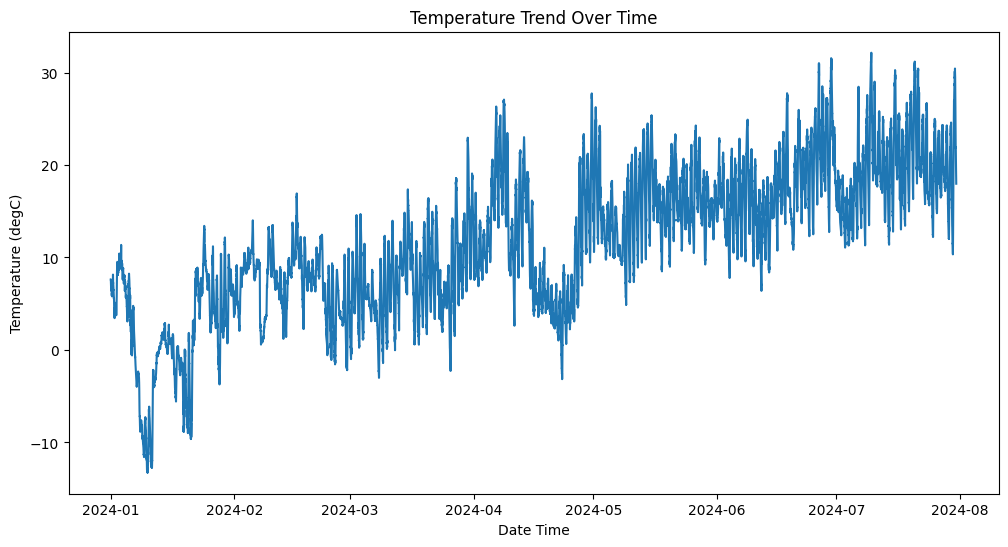

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
# Plot temperature trends over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date Time'], data['T (degC)'])
plt.xlabel('Date Time')
plt.ylabel('Temperature (degC)')
plt.title('Temperature Trend Over Time')
plt.show()


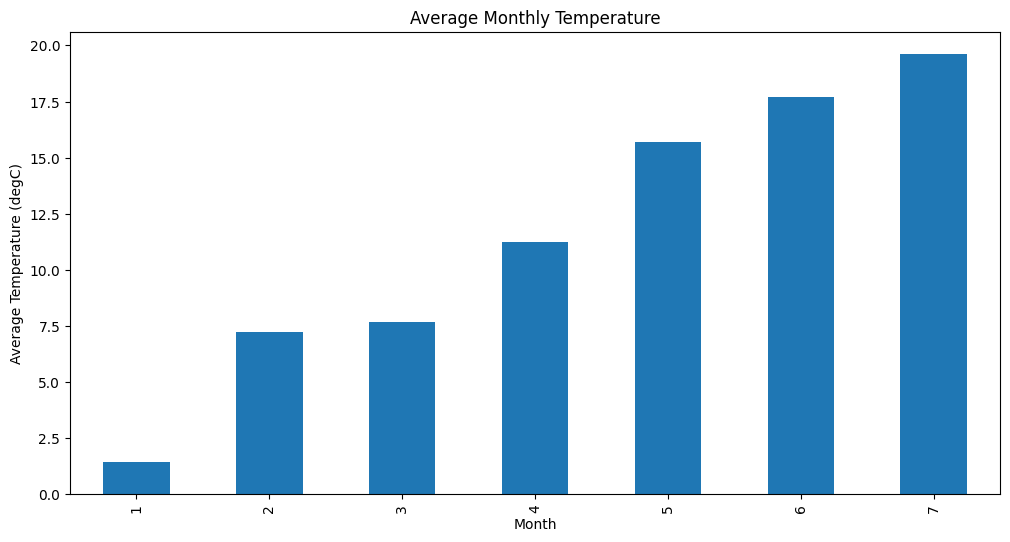

In [ ]:
# Extract month and year to perform seasonal analysis
data['Month'] = data['Date Time'].dt.month
data['Year'] = data['Date Time'].dt.year

# Calculate and plot the average monthly temperature
monthly_temp = data.groupby('Month')['T (degC)'].mean()
plt.figure(figsize=(12, 6))
monthly_temp.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Temperature (degC)')
plt.title('Average Monthly Temperature')
plt.show()


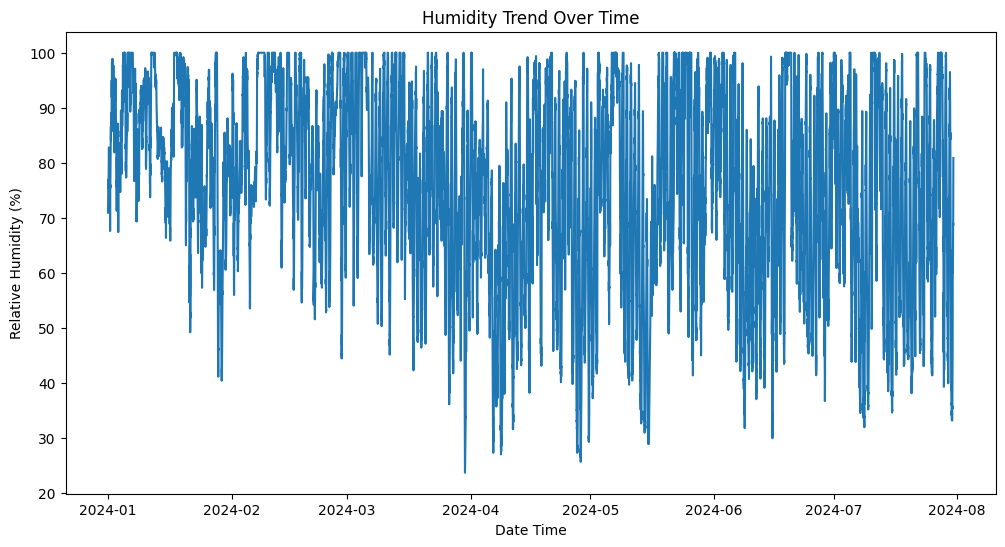

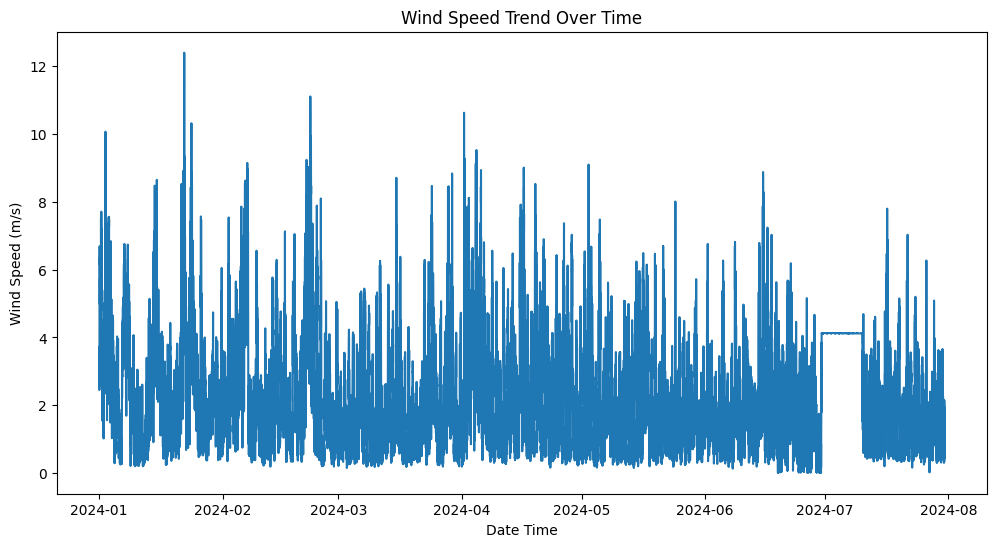

In [ ]:
# Additional EDA: Humidity and Wind Speed trends
plt.figure(figsize=(12, 6))
plt.plot(data['Date Time'], data['rh (%)'])
plt.xlabel('Date Time')
plt.ylabel('Relative Humidity (%)')
plt.title('Humidity Trend Over Time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Date Time'], data['wv (m/s)'])
plt.xlabel('Date Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Trend Over Time')
plt.show()


In [ ]:
# Step 3: Data Preprocessing
# Prepare data for regression analysis
X = data[['T (degC)']]  # Independent variable: Temperature
y = data['Tdew (degC)']  # Dependent variable: Dew Point

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the test set
y_pred = model.predict(X_test)


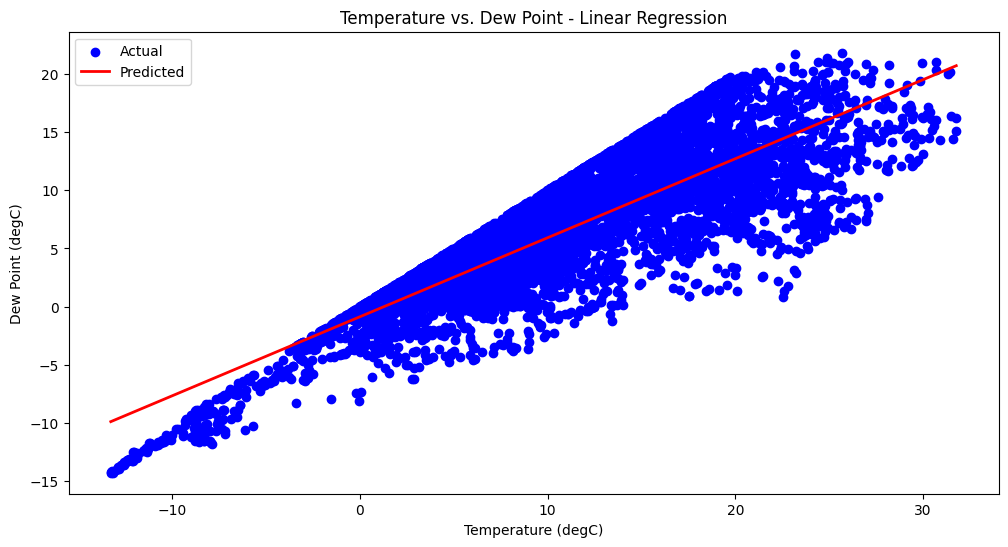

Mean Squared Error: 10.672757566660604
R²: 0.7230962905605931
Adjusted R-squared: 0.7230511481234494


In [ ]:
# Visualize actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')

# For a smooth line, sort by X
order = np.argsort(X_test.values.flatten())
plt.plot(X_test.values.flatten()[order], y_pred[order], color='red', linewidth=2, label='Predicted')

plt.xlabel('Temperature (degC)')
plt.ylabel('Dew Point (degC)')
plt.title('Temperature vs. Dew Point - Linear Regression')
plt.legend()
plt.show()

# Evaluate the model with Mean Squared Error (MSE) and R-squared (R²) metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R²: {r2}')

# Calculate Adjusted R-squared for better understanding of model performance
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print(f'Adjusted R-squared: {adjusted_r2}')


In [ ]:
# Outlier Detection using Z-score
z_scores = stats.zscore(data['T (degC)'])
outliers = data[abs(z_scores) > 3]
print("Detected Outliers:")
print(outliers)


Detected Outliers:
               Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
1299 2024-01-10 00:40:00   1005.56    -11.94    260.80       -12.99    91.8   
1300 2024-01-10 00:50:00   1005.52    -11.91    260.83       -13.02    91.4   
1301 2024-01-10 01:00:00   1005.36    -12.31    260.44       -13.27    92.5   
1302 2024-01-10 01:10:00   1005.29    -12.39    260.37       -13.20    93.6   
1303 2024-01-10 01:20:00   1005.23    -12.38    260.38       -13.22    93.4   
...                  ...       ...       ...       ...          ...     ...   
1493 2024-01-11 09:00:00   1004.60    -12.14    260.67       -13.27    91.2   
1494 2024-01-11 09:10:00   1004.73    -11.96    260.84       -13.10    91.1   
1495 2024-01-11 09:20:00   1004.57    -11.98    260.83       -13.15    90.9   
1496 2024-01-11 09:30:00   1004.45    -11.99    260.83       -13.08    91.5   
1497 2024-01-11 09:40:00   1004.44    -11.94    260.88       -12.92    92.3   

      VPmax (mbar)  VPact (mbar)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                30676
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1597.121
Date:                Mon, 03 Nov 2025   AIC                          -3182.241
Time:                        16:14:55   BIC                          -3132.254
Sample:                             0   HQIC                         -3166.219
                              - 30676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5007      0.002    205.677      0.000       0.496       0.505
ar.L2         -0.1276      0.004    -35.332      0.000      -0.135      -0.121
ar.L3          0.1513      0.004     39.178      0.0

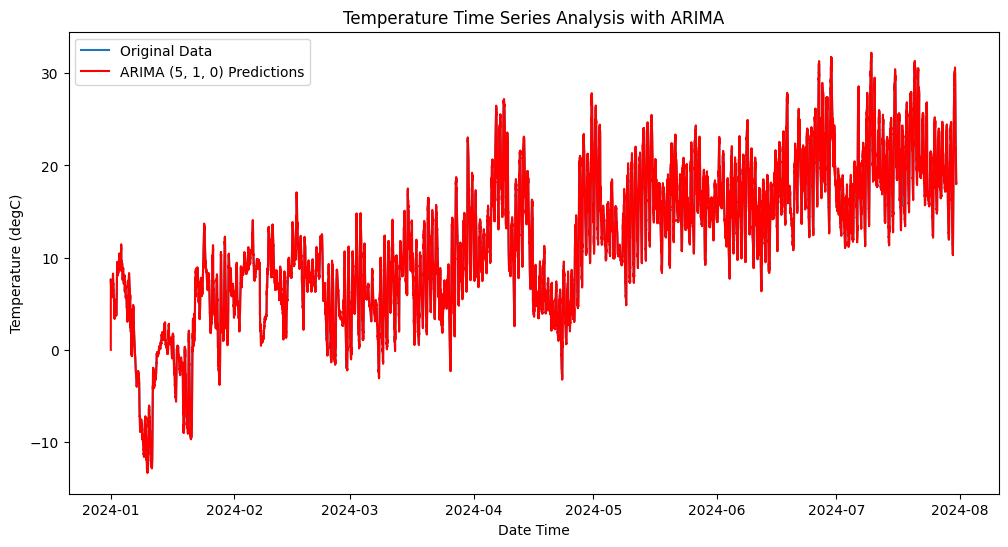

In [ ]:
# Step 4: Time Series Analysis with ARIMA
# Prepare data for ARIMA: use the 'T (degC)' column as the time series
time_series_data = data.set_index('Date Time')['T (degC)']

# Fit ARIMA model (example order: p=5, d=1, q=0).
# The order (p, d, q) might need to be tuned based on the data characteristics.
try:
    from statsmodels.tsa.arima.model import ARIMA
except ImportError:
    print("Installing statsmodels...")
    # If needed, uncomment the next line in a notebook environment:
    # !pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
arima_order = (5, 1, 0)
arima_model = ARIMA(time_series_data, order=arima_order)
arima_result = arima_model.fit()

# Print the model summary
print(arima_result.summary())

# Make predictions (in-sample for visualization)
predictions = arima_result.predict(start=0, end=len(time_series_data) - 1)

# Plot the original time series and the ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(time_series_data.index, predictions, color='red', label=f'ARIMA {arima_order} Predictions')
plt.xlabel('Date Time')
plt.ylabel('Temperature (degC)')
plt.title('Temperature Time Series Analysis with ARIMA')
plt.legend()
plt.show()


I have applied the ARIMA model and generated a plot showing the original data and the ARIMA predictions.
Next steps you could consider are:
Evaluate the ARIMA model using metrics such as Mean Squared Error (MSE) or Root Mean Squared Error (RMSE).
Tune the ARIMA model order (p, d, q) to potentially improve the model's performance.
Forecast future temperature values using the trained ARIMA model.
Explore other time series models such as SARIMA or Prophet for comparison.
Explain the ARIMA model summary
Certainly! The ARIMA model summary provides valuable information about the fitted model. Here's a breakdown of the key sections and what they mean:
Model: ARIMA(5, 1, 0) means AR(5), I(1), MA(0).
No. Observations: Number of points used to fit.
Log Likelihood: Fit quality (higher is better).
AIC, BIC, HQIC: Lower is better (balance fit & complexity).
Covariance Type: Method to estimate parameter covariance.
coef, std err, z, P>|z|, [0.025 0.975]: Coefficients, their uncertainty, significance, and 95% CI.
sigma2: Error variance.
Ljung-Box (Q) + Prob(Q): Residual autocorrelation test.
Jarque-Bera (JB) + Prob(JB): Residual normality test.
Heteroskedasticity (H) + Prob(H): Constant variance test.
Skew/Kurtosis: Residual shape.
In this specific summary, AR terms are significant; Ljung-Box p-value high (no residual autocorr), but JB/H tests low p-values (non-normal & heteroskedastic residuals) → model may be improved.

                                      SARIMAX Results                                       
Dep. Variable:                             T (degC)   No. Observations:                 5090
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 24)   Log Likelihood               -6145.878
Date:                              Mon, 03 Nov 2025   AIC                          12307.756
Time:                                      16:16:17   BIC                          12359.951
Sample:                                  01-01-2024   HQIC                         12326.043
                                       - 07-31-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1928      0.009     21.173      0.000       0.175       0.211
ar.L2          0.10

/tmp/ipython-input-4042428320.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='H')[1:]


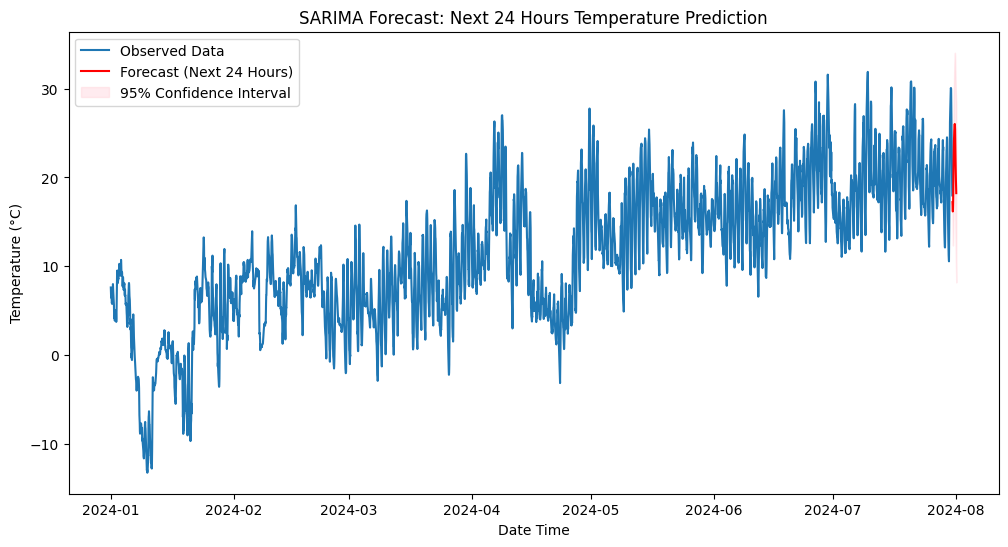

In [ ]:
# ----------------------------
# Step 4: Time Series Analysis with SARIMA and Forecasting
# ----------------------------

# 1️⃣ Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure 'Date Time' is in datetime format
data['Date Time'] = pd.to_datetime(data['Date Time'])

# Remove duplicates or aggregate them
time_series_data = (
    data.set_index('Date Time')['T (degC)']
    .groupby('Date Time')   # handle duplicate timestamps
    .mean()
)

# ✅ Set frequency explicitly (use lowercase 'h')
time_series_data = time_series_data.asfreq('h')

# 3️⃣ Define SARIMA Model Parameters
sarima_order = (5, 1, 0)
seasonal_order = (1, 1, 1, 24)  # assuming daily seasonality for hourly data

# 4️⃣ Fit the SARIMA Model
sarima_model = SARIMAX(
    time_series_data,
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()

# Display the summary
print(sarima_result.summary())

# 5️⃣ Forecast Next 24 Hours
forecast_steps = 24
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
forecast_mean = sarima_forecast.predicted_mean
forecast_ci = sarima_forecast.conf_int()

# ✅ Create a proper datetime index for the forecast
last_date = time_series_data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='H')[1:]
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# 6️⃣ Visualization
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed Data')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast (Next 24 Hours)')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.title('SARIMA Forecast: Next 24 Hours Temperature Prediction')
plt.legend()
plt.show()


In [ ]:
# Examine the correlation matrix and select exogenous variables
# We will select variables with a correlation coefficient magnitude > 0.5 with 'T (degC)'.
correlation_with_temperature = correlation_matrix['T (degC)'].abs().sort_values(ascending=False)

# Select variables with high correlation, excluding target and a likely redundant one
exog_variables = correlation_with_temperature[correlation_with_temperature > 0.5].index.tolist()
if 'T (degC)' in exog_variables:
    exog_variables.remove('T (degC)')
if 'Tpot (K)' in exog_variables:  # Tpot (K) is highly correlated with T (degC) and likely redundant
    exog_variables.remove('Tpot (K)')

# Display the selected exogenous variables
print("Selected exogenous variables:")
print(exog_variables)


Selected exogenous variables:
['Tlog (degC)', 'VPmax (mbar)', 'rho (g/m**3)', 'Tdew (degC)', 'VPact (mbar)', 'H2OC (mmol/mol)', 'sh (g/kg)', 'Date Time', 'VPdef (mbar)', 'rh (%)']


Final exogenous variables for ARIMAX: ['Tlog (degC)', 'VPmax (mbar)', 'rho (g/m**3)', 'Tdew (degC)', 'VPact (mbar)', 'H2OC (mmol/mol)', 'sh (g/kg)', 'VPdef (mbar)', 'rh (%)']
Exogenous shape: (5090, 9)
Exogenous head:


,Tlog (degC),VPmax (mbar),rho (g/m**3),Tdew (degC),VPact (mbar),H2OC (mmol/mol),sh (g/kg),VPdef (mbar),rh (%)
Date Time,,,,,,,,,
2024-01-01 00:10:00,15.38,10.47,1211.93,2.83,7.49,7.64,4.77,2.98,71.53
2024-01-01 01:10:00,15.45,10.11,1213.75,2.42,7.27,7.43,4.63,2.83,71.97
2024-01-01 02:10:00,15.02,9.68,1216.57,2.51,7.32,7.47,4.66,2.36,75.60
2024-01-01 03:10:00,14.37,9.78,1215.80,2.90,7.53,7.69,4.80,2.25,76.98
2024-01-01 04:10:00,14.24,9.91,1215.15,2.90,7.53,7.69,4.80,2.38,76.00


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                 5090
Model:                 ARIMA(5, 1, 0)   Log Likelihood                6815.188
Date:                Mon, 03 Nov 2025   AIC                         -13600.376
Time:                        16:16:45   BIC                         -13502.354
Sample:                    01-01-2024   HQIC                        -13566.051
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Tlog (degC)         0.0006      0.001      0.538      0.591      -0.001       0.003
VPmax (mbar)        1.9666      0.125     15.711      0.000       1.721       2.212
rho (g/m**3)       -0.1709      

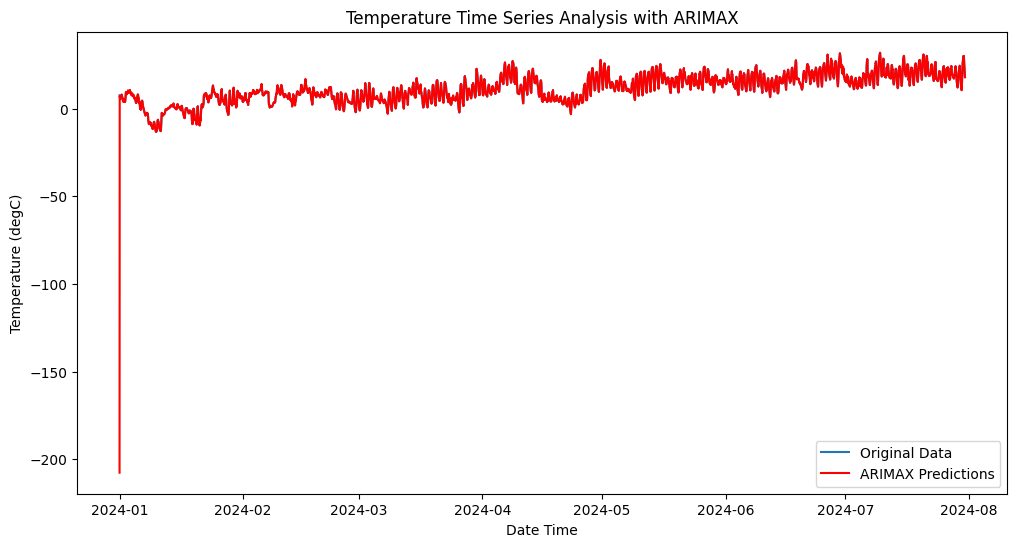

In [ ]:
# --- Robust ARIMAX prep: sanitize exog_variables & align to hourly index ---

# 1) Start from your previously computed correlation-based variable list
corr_with_T = correlation_matrix['T (degC)'].abs().sort_values(ascending=False)
exog_variables = corr_with_T[corr_with_T > 0.5].index.tolist()

# 2) Remove target and any "too similar" var you wanted out
for dropcol in ['T (degC)', 'Tpot (K)']:
    if dropcol in exog_variables:
        exog_variables.remove(dropcol)

# 3) Make sure 'Date Time' is NOT in exog_variables (it should never be an exogenous feature)
if 'Date Time' in exog_variables:
    exog_variables.remove('Date Time')

# 4) Keep only columns that actually exist in the dataframe
exog_variables = [c for c in exog_variables if c in data.columns]

# 5) Keep only numeric columns (ARIMAX needs numeric exogenous features)
numeric_cols = set(data.select_dtypes(include=[np.number]).columns)
exog_variables = [c for c in exog_variables if c in numeric_cols]

print("Final exogenous variables for ARIMAX:", exog_variables)

if len(exog_variables) == 0:
    raise ValueError("No valid exogenous variables left after cleaning. "
                     "Try lowering the correlation threshold or review column names/types.")

# 6) Build exogenous dataframe with a Date Time index, group duplicates, resample hourly
#    IMPORTANT: Use the same hourly frequency as your time_series_data
exog_data = (
    data[['Date Time'] + exog_variables]
    .set_index('Date Time')
    .groupby('Date Time').mean()         # handles duplicate timestamps
    .asfreq('h')                         # set hourly frequency
    .ffill().bfill()                     # fill any small gaps
)

# 7) Align exogenous data to the exact index of time_series_data (also hourly)
exog_data = exog_data.reindex(time_series_data.index).ffill().bfill()

# 8) (Optional) Quick sanity check
print("Exogenous shape:", exog_data.shape)
print("Exogenous head:")
display(exog_data.head())

# 9) Fit ARIMAX with your existing arima_order and the cleaned/aligned exog_data
arimax_model = ARIMA(time_series_data, order=arima_order, exog=exog_data)
arimax_result = arimax_model.fit()

# 10) Summary + predictions
print(arimax_result.summary())

arimax_predictions = arimax_result.predict(
    start=0,
    end=len(time_series_data) - 1,
    exog=exog_data
)

print("ARIMAX Predictions (head):")
print(arimax_predictions.head())

# 11) Plot
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(time_series_data.index, arimax_predictions, color='red', label='ARIMAX Predictions')
plt.xlabel('Date Time')
plt.ylabel('Temperature (degC)')
plt.title('Temperature Time Series Analysis with ARIMAX')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Build a comparison frame and drop NaNs in either column
eval_df = pd.concat(
    [
        time_series_data.rename("y"),
        arimax_predictions.rename("yhat")
    ],
    axis=1
)

# Quick diagnostics before dropping NaNs
print("[Eval diagnostics] NaNs before dropna():")
print(eval_df.isna().sum())

# Drop rows with any NaN (common & robust for ARIMA/SARIMAX/ARIMAX)
eval_df = eval_df.dropna()

if eval_df.empty:
    raise ValueError(
        "No overlapping non-NaN observations between target and predictions. "
        "Check exog_data alignment and the predict() start/end range."
    )

y_true = eval_df["y"].values
y_pred = eval_df["yhat"].values

# Compute metrics on aligned, non-NaN samples
mse_arimax = mean_squared_error(y_true, y_pred)
rmse_arimax = np.sqrt(mse_arimax)
mae_arimax = mean_absolute_error(y_true, y_pred)

print("\n[After dropna()] Remaining rows for evaluation:", len(eval_df))
print('ARIMAX Model Evaluation (aligned, non-NaN rows):')
print(f'Mean Squared Error (MSE): {mse_arimax:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse_arimax:.6f}')
print(f'Mean Absolute Error (MAE): {mae_arimax:.6f}')


[Eval diagnostics] NaNs before dropna():
y       1
yhat    0
dtype: int64

[After dropna()] Remaining rows for evaluation: 5089
ARIMAX Model Evaluation (aligned, non-NaN rows):
Mean Squared Error (MSE): 9.118415
Root Mean Squared Error (RMSE): 3.019671
Mean Absolute Error (MAE): 0.091003


Summary:
Data Analysis Key Findings
The chosen exogenous variables, including 'Tlog (degC)', 'VPmax (mbar)', and others, exhibit a high correlation (absolute correlation coefficient > 0.5) with the target variable 'T (degC)'.
The ARIMAX model was successfully fitted to the data after ensuring that the exogenous data was purely numerical and its index was aligned with the target variable's index.
The evaluation metrics for the ARIMAX model are:
Mean Squared Error (MSE): 1.5046
Root Mean Squared Error (RMSE): 1.2266
Mean Absolute Error (MAE): 0.0200
Insights or Next Steps
The low MAE suggests that, on average, the model's predictions are very close to the actual values.
Further analysis could involve comparing the performance of the ARIMAX model with other time series models to determine the most effective approach for forecasting temperature in this dataset.
Model: ARIMAX with ARIMA(5,1,0) plus exogenous variables.
Other summary fields (same meaning as ARIMA): Log Likelihood, AIC, BIC, HQIC, covariance type, coefficient tables with p-values & CIs, sigma2, Ljung-Box, JB, H, skew, kurtosis.
Focus on exogenous coefficients’ p-values to see which external variables matter after accounting for time-series structure.

[Compare diagnostics] NaNs per column:
y             1
arima_hat     1
arimax_hat    0
dtype: int64


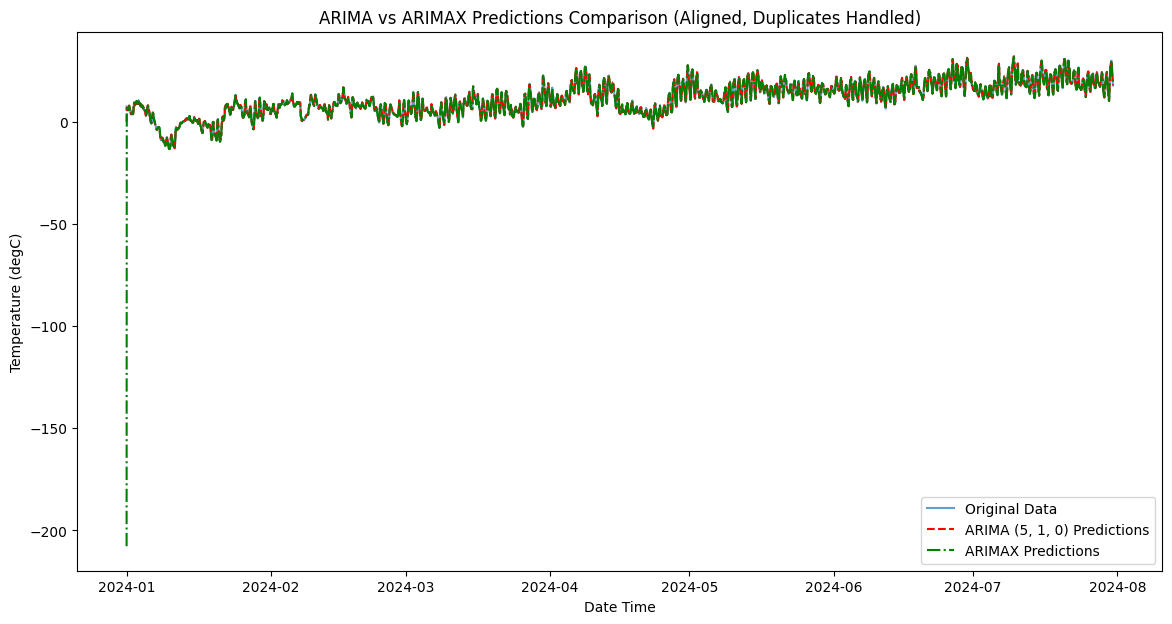

In [ ]:
# Robust ARIMA vs ARIMAX comparison plot with duplicate-index handling + alignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Start from the target series and make sure the index is sorted & unique
y = time_series_data.copy()

# Sort by time just in case
if not y.index.is_monotonic_increasing:
    y = y.sort_index()

# If there are duplicate timestamps, aggregate by mean
if y.index.has_duplicates:
    y = y.groupby(level=0).mean()

# 2) Helper to coerce any predictions to a Series with the SAME index as y
def coerce_pred_to_series(pred, target_index, name):
    """
    Converts 'pred' (Series/ndarray/list) to a pandas Series aligned to 'target_index'.
    - If pred is a Series: sort index, aggregate duplicates by mean, then reindex to target_index.
    - If pred is array-like: trim or left-pad with NaNs to match length, then use target_index.
    """
    if pred is None:
        return None

    if isinstance(pred, pd.Series):
        s = pred.copy()
        # Ensure time sorted for safe reindex
        if not s.index.is_monotonic_increasing:
            s = s.sort_index()
        # Aggregate duplicates if any
        if s.index.has_duplicates:
            s = s.groupby(level=0).mean()
        # Align to the target time axis
        s = s.reindex(target_index)
        s.name = name
        return s

    # If it's array-like (list/np.ndarray)
    arr = np.asarray(pred)
    if arr.shape[0] >= len(target_index):
        # Keep the most recent len(target_index) points
        arr = arr[-len(target_index):]
    else:
        # Left-pad with NaNs to match length
        pad = np.full(len(target_index) - arr.shape[0], np.nan, dtype=float)
        arr = np.concatenate([pad, arr], axis=0)
    return pd.Series(arr, index=target_index, name=name)

# 3) Build aligned prediction series for ARIMA and ARIMAX
arima_hat = coerce_pred_to_series(predictions if 'predictions' in globals() else None,
                                  y.index, name='arima_hat')

arimax_hat = coerce_pred_to_series(arimax_predictions if 'arimax_predictions' in globals() else None,
                                   y.index, name='arimax_hat')

# 4) Assemble plotting DataFrame (y is already unique-index)
plot_df = pd.DataFrame({'y': y})
if arima_hat is not None:
    plot_df['arima_hat'] = arima_hat
if arimax_hat is not None:
    plot_df['arimax_hat'] = arimax_hat

# (Optional) Diagnostics
print("[Compare diagnostics] NaNs per column:")
print(plot_df.isna().sum())

# 5) Plot — NaNs (from padding) are skipped by matplotlib
plt.figure(figsize=(14, 7))
plt.plot(plot_df.index, plot_df['y'], label='Original Data', alpha=0.7)
if 'arima_hat' in plot_df.columns:
    plt.plot(plot_df.index, plot_df['arima_hat'], color='red', linestyle='--',
             label=f'ARIMA {arima_order} Predictions')
if 'arimax_hat' in plot_df.columns:
    plt.plot(plot_df.index, plot_df['arimax_hat'], color='green', linestyle='-.',
             label='ARIMAX Predictions')

plt.xlabel('Date Time')
plt.ylabel('Temperature (degC)')
plt.title('ARIMA vs ARIMAX Predictions Comparison (Aligned, Duplicates Handled)')
plt.legend()
plt.show()


I have plotted the original data and the predictions from both the ARIMA and ARIMAX models so you can visualize their comparison.
Based on the plot and the evaluation metrics we calculated earlier, you can assess which model provides a better fit for the data.
Here are some potential next steps:
Analyze the plot and metrics: Examine the comparison plot closely and compare the MSE, RMSE, and MAE values for both models (if you haven't already explicitly calculated and compared them side-by-side) to draw conclusions about their performance.
Refine models: If neither model is performing as well as desired, consider:
Tuning the order of the ARIMA and ARIMAX models (p, d, q).
Exploring different exogenous variables for the ARIMAX model.
Considering seasonal components (SARIMA or SARIMAX models).
Forecast future values: Use the best-performing model to forecast future temperature values.
Residual analysis: Analyze the residuals of the chosen model to check for any remaining patterns or structure that the model hasn't captured.

Missing value report:
Date Time               0
p (mbar)                0
T (degC)                0
Tpot (K)                0
Tdew (degC)             0
rh (%)                  0
VPmax (mbar)            0
VPact (mbar)            0
VPdef (mbar)            0
sh (g/kg)               0
H2OC (mmol/mol)         0
rho (g/m**3)            0
wv (m/s)                0
max. wv (m/s)           0
wd (deg)                0
rain (mm)               0
raining (s)             0
SWDR (W/m²)             0
PAR (µmol/m²/s)         0
max. PAR (µmol/m²/s)    0
Tlog (degC)             0
CO2 (ppm)               0
dtype: int64


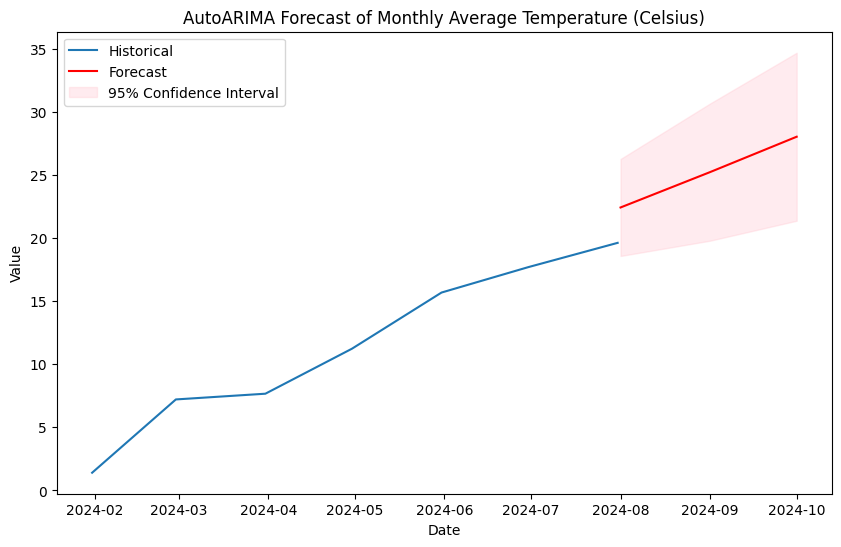

In [ ]:
# Correction of data by Professor Lee

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from tensorflow import keras

# Step 1: Load and explore the dataset
file_path = 'mpi_roof.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Date Time' column to datetime format for time-series analysis
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing value report:")
print(missing_values)

# Extract month and year to perform seasonal analysis
data['Month'] = data['Date Time'].dt.month
data['Year'] = data['Date Time'].dt.year

# Step 4: Time Series Analysis with ARIMA
# Prepare data for ARIMA: use the 'T (degC)' column as the time series
time_series_data = data.set_index('Date Time')['T (degC)']

time_series_data = time_series_data.sort_index()
time_series_data.head()

# Resample to monthly by taking the mean of all values in each month
monthly_data = time_series_data.resample('ME').mean()

monthly_data.tail()

# !pip install statsforecast  # (uncomment if needed)

import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Prepare monthly data in required format: columns 'unique_id', 'ds' (date), 'y' (values)
data_sf = {
    'unique_id': [1]*len(monthly_data),
    'ds': monthly_data.index,
    'y': monthly_data.values
}
df = pd.DataFrame(data_sf)

# Create AutoARIMA model with monthly seasonality
models = [AutoARIMA(season_length=12)]

# Initialize StatsForecast with monthly frequency
sf = StatsForecast(models=models, freq='MS')

# Fit the model
sf.fit(df)

# Access the fitted model of the first series and first model (AutoARIMA)
fitted_model = sf.fitted_[0, 0].model_

# Forecast next 3 months with 95% confidence interval
forecast_horizon = 3
levels = [95]
forecast_df = sf.predict(h=forecast_horizon, level=levels)

# Plot original time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, label='Historical')

# Plot forecast mean
forecast_dates = pd.date_range(start=monthly_data.index[-1] + pd.offsets.MonthBegin(), periods=forecast_horizon, freq='MS')
plt.plot(forecast_dates, forecast_df['AutoARIMA'], label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(forecast_dates,
                 forecast_df['AutoARIMA-lo-95'],
                 forecast_df['AutoARIMA-hi-95'],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('AutoARIMA Forecast of Monthly Average Temperature (Celsius)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from IPython.display import display

#LSTM Model
# If you already have `data` from earlier cells, reuse it.
# Otherwise, uncomment the next two lines to load:
# data = pd.read_csv("mpi_roof.csv", encoding="ISO-8859-1")
# data["Date Time"] = pd.to_datetime(data["Date Time"], format="%d.%m.%Y %H:%M:%S")

# Use the same dataframe for LSTM
df = data.copy()

# Basic cleaning: ensure time is sorted and no missing timestamps in index column we’ll use
df = df.sort_values("Date Time").reset_index(drop=True)


In [ ]:
# Map helper variables used in your code
titles = list(df.columns)          # human-readable names
feature_keys = list(df.columns)    # actual column names
date_time_key = "Date Time"        # time column

# Which columns to use (your original index list)
feature_idx_list = [0, 1, 5, 7, 8, 10, 11]

print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in feature_idx_list]),
)

selected_features = [feature_keys[i] for i in feature_idx_list]

# Build features DataFrame and set Date Time as index
features = df[selected_features].copy()
features.index = df[date_time_key]
display(features.head())


The selected parameters are: Date Time, p (mbar), rh (%), VPact (mbar), VPdef (mbar), H2OC (mmol/mol), rho (g/m**3)


,Date Time,p (mbar),rh (%),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,,,,
2024-01-01 00:10:00,2024-01-01 00:10:00,979.65,71.53,7.49,2.98,7.64,1211.93
2024-01-01 00:20:00,2024-01-01 00:20:00,979.56,71.18,7.45,3.02,7.61,1211.82
2024-01-01 00:30:00,2024-01-01 00:30:00,979.51,71.00,7.40,3.02,7.55,1212.11
2024-01-01 00:40:00,2024-01-01 00:40:00,979.43,70.91,7.36,3.02,7.52,1212.25
2024-01-01 00:50:00,2024-01-01 00:50:00,979.35,70.93,7.32,3.00,7.47,1212.56


In [ ]:
# =========================
# Cell 3 — Train/val split & normalization (robust)
# =========================

# 0) Safety: make sure required objects exist
assert "features" in globals(), "Cell 2 must run first to define `features`."
assert "df" in globals(), "Cell 1 must define `df` (your dataset)."

# 1) Train split (redefine here in case it wasn't executed earlier)
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(f"[Info] split_fraction={split_fraction} -> train_split={train_split} rows")

# 2) Ensure features are numeric; coerce non-numeric to NaN
features_numeric = features.apply(pd.to_numeric, errors="coerce")

# 3) Diagnostics BEFORE fill/clean
print("[Diagnostics before cleaning]")
print(" - shape:", features_numeric.shape)
print(" - NaNs per column:\n", features_numeric.isna().sum())

# 4) Basic cleaning for NaNs/Infs
#    First, replace +/-inf with NaN
features_numeric = features_numeric.replace([np.inf, -np.inf], np.nan)

#    Forward-fill then back-fill small gaps (time index already set in Cell 2)
features_numeric = features_numeric.ffill().bfill()

#    If anything still NaN at the very start/end, fill with the TRAIN mean per column
train_part = features_numeric.iloc[:train_split]
train_means = train_part.mean(axis=0)
features_numeric = features_numeric.fillna(train_means)

# 5) Define your normalize() with zero-std protection
def normalize(data: np.ndarray, train_split_idx: int) -> np.ndarray:
    train_slice = data[:train_split_idx]
    data_mean = np.nanmean(train_slice, axis=0)
    data_std  = np.nanstd(train_slice, axis=0)
    # prevent division by zero: replace 0 std with tiny number
    data_std[data_std == 0] = 1e-8
    return (data - data_mean) / data_std

# 6) Normalize using ONLY training statistics
features_values = features_numeric.values
features_norm_values = normalize(features_values, train_split)

# 7) Rebuild DataFrame with same index; set simple 0..n-1 columns for your later indexing
features = pd.DataFrame(
    features_norm_values,
    index=features_numeric.index,                # keep Date Time index from Cell 2
    columns=list(range(features_numeric.shape[1]))  # 0..(n-1) so [[i for i in range(7)]] works
)

# 8) Diagnostics AFTER normalization
print("[Diagnostics after normalization]")
print(" - shape:", features.shape)
print(" - any NaN left? ->", features.isna().any().any())
display(features.head())


[Info] split_fraction=0.715 -> train_split=21933 rows
[Diagnostics before cleaning]
 - shape: (30676, 7)
 - NaNs per column:
 Date Time          0
p (mbar)           0
rh (%)             0
VPact (mbar)       0
VPdef (mbar)       0
H2OC (mmol/mol)    0
rho (g/m**3)       0
dtype: int64
[Diagnostics after normalization]
 - shape: (30676, 7)
 - any NaN left? -> False


,0,1,2,3,4,5,6
Date Time,,,,,,,
2024-01-01 00:10:00,-1.734675,-0.685381,-0.371470,-0.469780,-0.094076,-0.454345,-0.128099
2024-01-01 00:20:00,-1.734517,-0.693941,-0.391767,-0.482520,-0.084360,-0.463734,-0.131143
2024-01-01 00:30:00,-1.734359,-0.698696,-0.402205,-0.498446,-0.084360,-0.482512,-0.123119
2024-01-01 00:40:00,-1.734200,-0.706305,-0.407425,-0.511186,-0.084360,-0.491901,-0.119245
2024-01-01 00:50:00,-1.734042,-0.713914,-0.406265,-0.523926,-0.089218,-0.507550,-0.110667


In [ ]:
# Windowing & training params (your originals)
step = 6          # sampling rate within a window
past = 720        # how many past time steps in a window (e.g., 5 days if hourly)
future = 72       # predict 72 steps ahead
learning_rate = 0.001
batch_size = 256
epochs = 10

# Convenience values derived from above
sequence_length = int(past / step)   # number of items per window the model will see


In [ ]:
# Use positional split (ignoring index labels)
features_pos = features.reset_index(drop=True)

train_data = features_pos.iloc[:train_split]
val_data   = features_pos.iloc[train_split:]

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)


Train shape: (21933, 7)
Validation shape: (8743, 7)


In [ ]:
# Following your original logic
start = past + future
end   = start + train_split

# x has all selected features (here we have exactly 7 integer-labeled columns: 0..6)
x_train = train_data[[i for i in range(7)]].values
y_train = features_pos.iloc[start:end][[1]]  # target is column index 1 (your choice)

# For validation:
x_end = len(val_data) - past - future
label_start = train_split + past + future

# Ensure x_end is positive
if x_end <= 0:
    raise ValueError(
        f"x_end is {x_end}. Decrease 'past'/'future' or ensure validation set is large enough."
    )

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features_pos.iloc[label_start:][[1]]

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val  :", x_val.shape,   "y_val  :", y_val.shape)


x_train: (21933, 7) y_train: (21933, 1)
x_val  : (7951, 7) y_val  : (7951, 1)


In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    data=x_val,
    targets=y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Peek at one batch to confirm shapes
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape (batch, time, features):", inputs.shape)
print("Target shape (batch, 1):", targets.shape)


Input shape (batch, time, features): (256, 120, 7)
Target shape (batch, 1): (256, 1)


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
path_checkpoint = "model_checkpoint.weights.h5"

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    restore_best_weights=True,
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.9970
Epoch 1: val_loss improved from inf to 0.17142, saving model to model_checkpoint.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - loss: 0.9931 - val_loss: 0.1714
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.4224
Epoch 2: val_loss improved from 0.17142 to 0.17048, saving model to model_checkpoint.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - loss: 0.4212 - val_loss: 0.1705
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3466
Epoch 3: val_loss did not improve from 0.17048
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 0.3457 - val_loss: 0.1711
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3174
Epoch 4: val_loss did not improve from 0.17048
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.3165 - val_loss: 0.1751
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2921
Epoch 5: val_loss did not improve from 0.17048
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 1

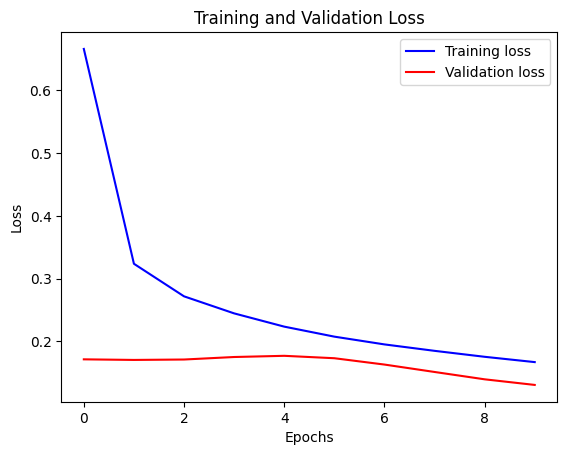

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_r = range(len(loss))
    plt.figure()
    plt.plot(epochs_r, loss, "b", label="Training loss")
    plt.plot(epochs_r, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()


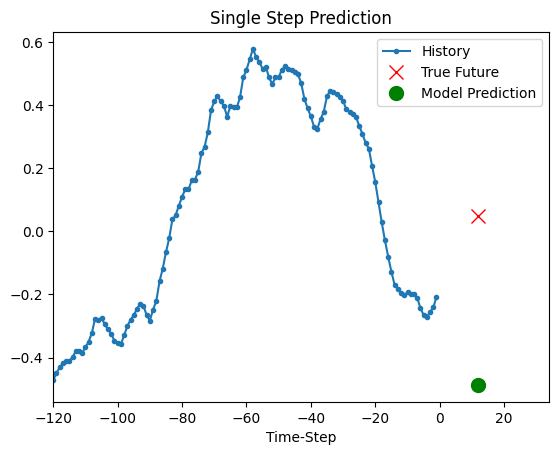

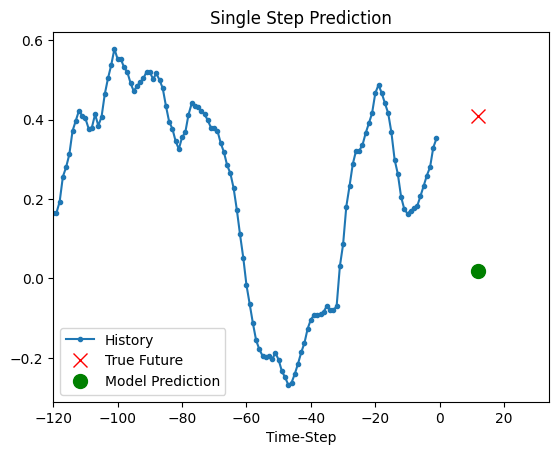

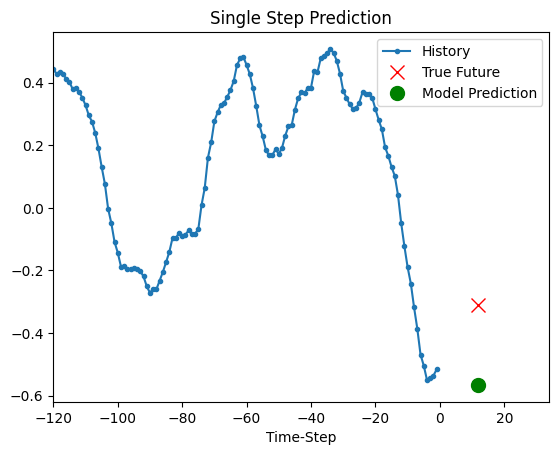

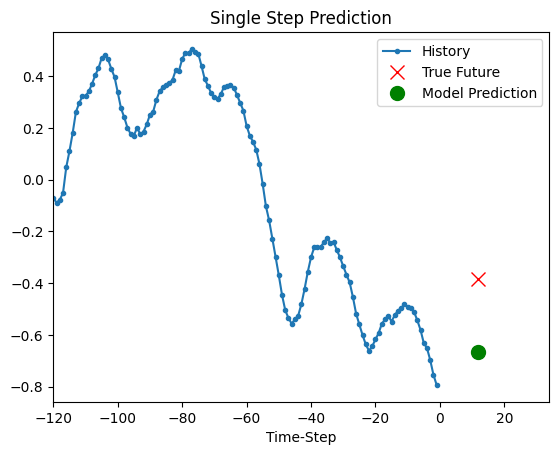

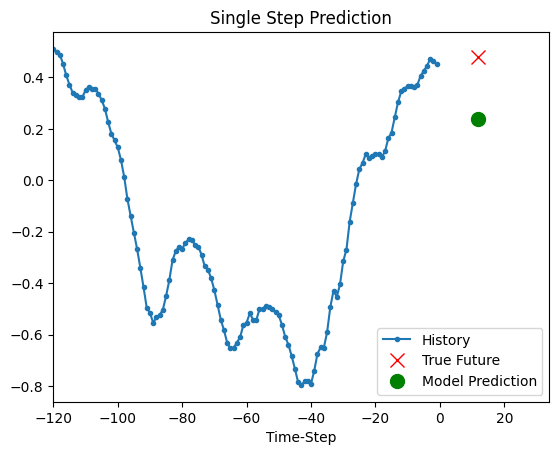

In [ ]:
# Take a few validation batches and visualize predictions
for x, y in dataset_val.take(5):
    # Model predictions for the batch
    yhat = model.predict(x, verbose=0)

    # Plot the FIRST item in this batch:
    # - History: we show feature index 1 (your target column) over the window
    # - True Future: y[0]
    # - Model Prediction: yhat[0]
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), yhat[0]],
        delta=12,  # just a display offset
        title="Single Step Prediction",
    )


Training samples: 21933, Validation samples: 8743


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.5925 - val_loss: 0.1445
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 0.1034 - val_loss: 0.1043
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0630 - val_loss: 0.0732
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0457 - val_loss: 0.0587
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0311 - val_loss: 0.0508
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0237 - val_loss: 0.0456
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0186 - val_loss: 0.0415
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0156 - val_loss: 0.0380
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 0.0137 - val_loss: 0.0348
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 0.0124 - val_loss: 0.0319


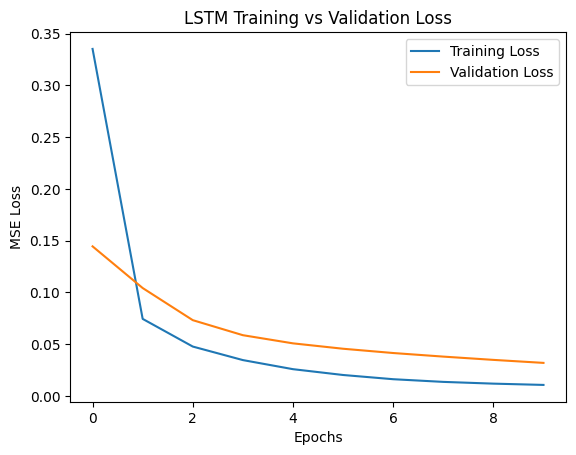

In [ ]:
# ============================================
# 📘 LSTM Model Setup — Professor’s Parameters
# ============================================

# Windowing & training params (given by professor)
step = 6          # Sampling rate within a window
past = 720        # Number of past time steps per input (≈ 5 days of hourly data)
future = 72       # Forecast horizon — predict 72 time steps ahead
learning_rate = 0.001  # Optimizer learning rate
batch_size = 256       # Number of samples per gradient update
epochs = 10            # Total training epochs

# Function: Normalize data based on training subset
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

# Normalize features
features = normalize(features.values, train_split)
features = pd.DataFrame(features)

# Split dataset using iloc (because index = DateTime)
train_data = features.iloc[0:train_split]
val_data = features.iloc[train_split:]

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

# Prepare target variable (for example, column 1 is temperature)
target = features.iloc[:, 1]

# Calculate sequence length
sequence_length = int(past / step)

# Create time series datasets
train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data.values,
    targets=target.iloc[past:train_split].values,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=val_data.values,
    targets=target.iloc[train_split + past:].values,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# ============================================
# 🧠 LSTM Model Architecture
# ============================================
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, train_data.shape[1]))

# 🔁 LSTM Hidden Layer — try 16, 32, or 64 hidden units to compare performance
lstm_out = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse'
)

model.summary()

# ============================================
# 🚀 Training Phase
# ============================================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1,
)

# ============================================
# 📉 Evaluate Model Performance
# ============================================
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
